In [1]:
!pip freeze

joblib==1.4.2
numpy==2.1.2
scikit-learn==1.5.2
scipy==1.14.1
threadpoolctl==3.5.0


In [2]:
# imports
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import joblib
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import layers, models

In [3]:
# read in data and preprocess
images_path = './data/asl_dataset/'
images = []

for directory in os.listdir(images_path):
    for file in os.listdir(images_path+directory):
        file_path = images_path+directory+'/'+file
        image = Image.open(file_path)
        image = image.convert('L') # convert to grayscale
        image = image.resize((128, 128)) # resize
        # image.save('./data/resized/'+file) # uncomment to save the resized image
        image = np.array(image) # convert to array
        image = image / 255.0 # normalize
        images.append((directory, image))

x = [image[1] for image in images]
y = [image[0] for image in images]



In [13]:
y

['0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2'

In [4]:
# label_binarizer = LabelBinarizer()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
# print(y_test[0])
# binarized = label_binarizer.fit_transform(y_test)
# print(binarized[0])
# undone = label_binarizer.inverse_transform(binarized)
# print(undone)


In [5]:
x_train = np.array(x_train)
x_test = np.array(x_test)


# binarize the labels
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.transform(y_test)
joblib.dump(label_binarizer, './models/label_binarizer1.pkl') # save label binarizer



# print(x_train.shape)
# print(y_train.shape)
# print(x_test.shape)
# print(y_test.shape)
print(y_test[0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]


In [6]:
model = models.Sequential([
    layers.Conv2D(8, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(36, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=30, batch_size=128, validation_split=0.2)

C:\Users\calif\Desktop\DataMining\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 796ms/step - accuracy: 0.1147 - loss: 3.3493 - val_accuracy: 0.5484 - val_loss: 1.9983
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 768ms/step - accuracy: 0.4729 - loss: 1.9062 - val_accuracy: 0.7717 - val_loss: 0.9881
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 717ms/step - accuracy: 0.6821 - loss: 1.0481 - val_accuracy: 0.8486 - val_loss: 0.6248
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 822ms/step - accuracy: 0.7908 - loss: 0.6815 - val_accuracy: 0.8561 - val_loss: 0.5689
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 684ms/step - accuracy: 0.8184 - loss: 0.5449 - val_accuracy: 0.8883 - val_loss: 0.4810
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 684ms/step - accuracy: 0.8738 - loss: 0.4043 - val_accuracy: 0.8983 - val_loss: 0.4080
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 812ms/step - accuracy: 0.9072 - loss: 0.3177 - val_accuracy: 0.9057 - val_loss: 0.3749
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 724ms/step - accuracy: 0.9245 - loss: 0.2400 - val_accurac

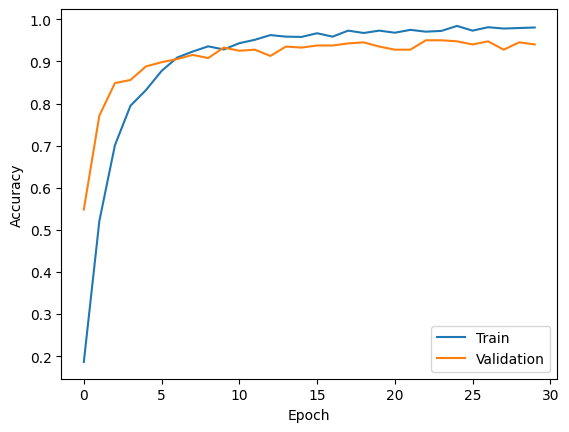

In [7]:
# plot model performance
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

In [8]:
# print results of test data ran through model
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(test_loss)
print(test_accuracy)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9855 - loss: 0.0629
0.1234176903963089
0.9721670150756836


In [9]:
# save model
model.save('./models/model1.keras')

In [14]:
t = np.expand_dims(x_test[0], axis=0) 
predictions = model.predict(t)
rounded = np.round(predictions)
predicted_class = np.argmax(predictions)

print(predicted_class)
print(label_binarizer.classes_[predicted_class])
original_label = label_binarizer.inverse_transform(rounded)
original_label[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
29
t


't'

In [53]:
classes = {0: "0",
            1: "1",
            2: "2",
            3: "3",
            4: "4",
            5: "5",
            6: "6",
            7: "7",
            8: "8",
            9: "9",
            10: "a",
            11: "b",
            12: "c",
            13: "d",
            14: "e",
            15: "f",
            16: "g",
            17: "h",
            18: "i",
            19: "j",
            20: "k",
            21: "l",
            22: "m",
            23: "n",
            24: "o",
            25: "p",
            26: "q",
            27: "r",
            28: "s",
            29: "t",
            30: "u",
            31: "v",
            32: "w",
            33: "x",
            34: "y",
            35: "z",
            }

print(x_test[0])
# for a in x_test:
#     for b in a:
#         print(b)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step


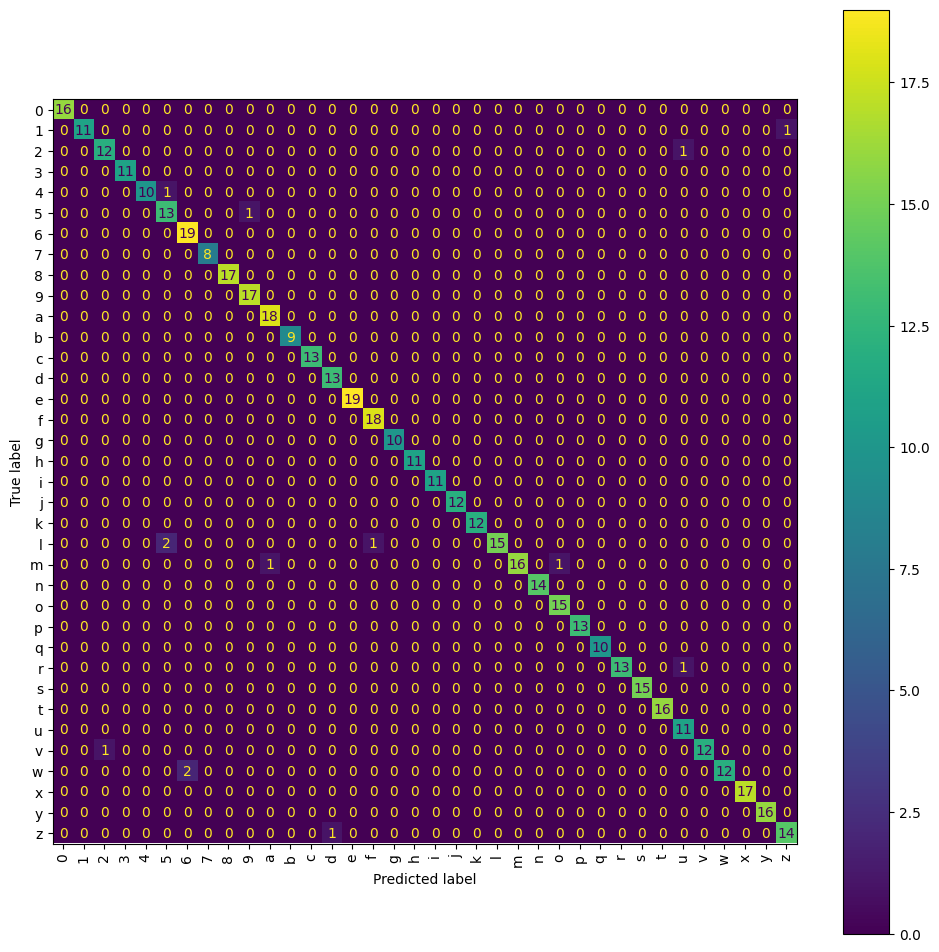

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# print(classification_report(y_true, y_pred_classes, target_names= classes.values())) 

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes.values())
disp.plot( values_format='d', ax=plt.gca())
plt.xticks(rotation=90)
plt.show()